In [1]:
! pip install torchvision

In [2]:
#importing required libraries

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline 

import matplotlib.animation as animation
import random
from IPython.display import HTML 

from torch.autograd import Variable
from torchvision.utils import save_image
import os 

import torch.backends.cudnn as cudnn

from matplotlib.pyplot import *
from pylab import *
import torchvision.utils as vutils

In [3]:
transform=transforms.Compose([
        torchvision.transforms.Grayscale(num_output_channels = 1), 
        transforms.ToTensor(),
        transforms.Normalize ((0.5,),(0.5,))
   ])

In [4]:
train_set=torchvision.datasets.CIFAR10(
    root='./data'
    ,train=True
    ,download=True
    ,transform=transform
)


test_set=torchvision.datasets.CIFAR10(
    root='./data'
    ,train=False
    ,download=True
    ,transform=transform
)



Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
batch_size = 16
workers = 0

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [7]:
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle = True 
   
)   



In [8]:

#----------------------#

dataiter = iter(train_loader)
images,labels = dataiter.next()
print(labels[0:])
print(images.size())

classes = ['airplane','automobile','bird','cat','deer','dog',
          'frog','horse','ship','truck']

tensor([5, 5, 7, 0, 9, 1, 2, 6, 2, 9, 2, 1, 6, 2, 7, 1])
torch.Size([16, 1, 32, 32])


tensor([6, 5, 0, 1, 6, 1, 5, 2, 9, 8, 2, 4, 3, 7, 8, 0])
torch.Size([16, 1, 32, 32])
torch.Size([16, 1024])


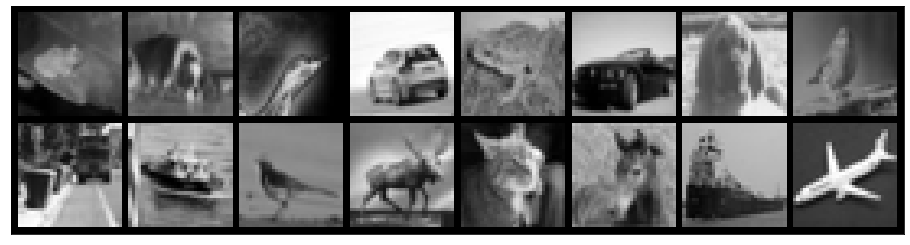

In [9]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
test = images.view(images.size(0), -1) #Matrix flattening

print(labels[0:])
print(images.size())
print(test.size())

classes = ['airplane','automobile','bird','cat','deer','dog',
          'frog','horse','ship','truck']


def imshow(img):
    img -= img.min()
    img /= img.max()
    im = torchvision.utils.make_grid(img)
    nping = im.numpy()
    plt.figure(figsize = (16,16))
    plt.imshow(np.transpose(nping , (1,2,0)))
    plt.xticks([])
    plt.yticks([])
    
    plt.show()
    
imshow(images)

In [10]:
def init_weight(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1: 
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [23]:
z_size = 100 #noise

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 4*4*256),
            
        )

        self.cnn = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.model(z)
        x = x.view(-1, 256, 4, 4)
        x = self.cnn(x)
        return x

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.cnn = nn.Sequential(
            #32*32*1
            nn.Conv2d(1, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            #16*16*64
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            #8*8*128
            nn.Conv2d(64, 256,  4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            #4*4*256
        )
        self.fc = nn.Sequential(
            nn.Linear(4*4*256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(-1, 4*4*256)
        x = self.fc(x)
        return x

In [13]:
D = Discriminator()

D.apply(init_weight)

Discriminator(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
  )
  (fc): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [14]:
G = Generator()

G.apply(init_weight)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=4096, bias=True)
  )
  (cnn): Sequential(
    (0): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): Tanh()
  )
)

In [15]:
for name, param in G.named_parameters():
    print(name, '\t\t', param.shape)

model.0.weight 		 torch.Size([4096, 100])
model.0.bias 		 torch.Size([4096])
cnn.0.weight 		 torch.Size([256])
cnn.0.bias 		 torch.Size([256])
cnn.1.weight 		 torch.Size([256, 64, 4, 4])
cnn.1.bias 		 torch.Size([64])
cnn.2.weight 		 torch.Size([64])
cnn.2.bias 		 torch.Size([64])
cnn.4.weight 		 torch.Size([64, 32, 4, 4])
cnn.4.bias 		 torch.Size([32])
cnn.5.weight 		 torch.Size([32])
cnn.5.bias 		 torch.Size([32])
cnn.7.weight 		 torch.Size([32, 1, 4, 4])
cnn.7.bias 		 torch.Size([1])


In [16]:
for name, param in D.named_parameters():
    print(name, '\t\t', param.shape)

cnn.0.weight 		 torch.Size([32, 1, 4, 4])
cnn.0.bias 		 torch.Size([32])
cnn.1.weight 		 torch.Size([32])
cnn.1.bias 		 torch.Size([32])
cnn.3.weight 		 torch.Size([64, 32, 4, 4])
cnn.3.bias 		 torch.Size([64])
cnn.4.weight 		 torch.Size([64])
cnn.4.bias 		 torch.Size([64])
cnn.6.weight 		 torch.Size([256, 64, 4, 4])
cnn.6.bias 		 torch.Size([256])
cnn.7.weight 		 torch.Size([256])
cnn.7.bias 		 torch.Size([256])
fc.0.weight 		 torch.Size([1, 4096])
fc.0.bias 		 torch.Size([1])


In [17]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [18]:
def to_var(x):
    if torch.cuda.is_available():
        x=x.cuda()
    return Variable(x)

def denorm(x):
    out = (x+1) / 2
    return out.clamp(0,1)



In [20]:
#setting the learning rate
lr_g = 0.002
lr_d = 0.0002

#Number of samples to take a random distribution from
rand_num = 9

#Number of epochs
num_epochs = 100

#select min batch size
batch_size = 16

#Number of batches per Epoch
num_batches = len(train_loader)

In [21]:
discriminator = Discriminator()
generator = Generator()

# The classification loss of Discriminator, binary classification, 1 -> real sample, 0 -> fake sample
criterion = nn.BCELoss()

# Define optimizers
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr_g)


rand_z = Variable(torch.randn(rand_num, 100))

Epoch: 0,    G_loss: 2.1199931849861144,   D_loss: 0.7201593005228043  


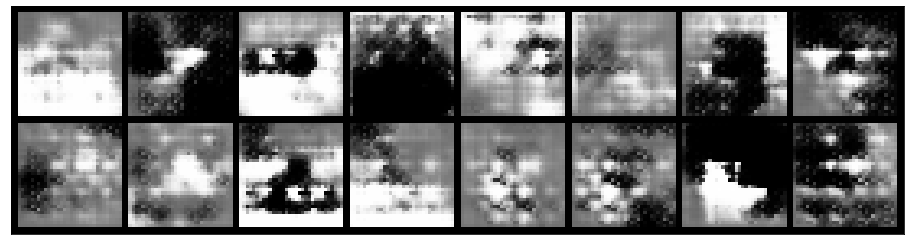

Epoch: 1,    G_loss: 2.168707219371796,   D_loss: 0.6917588391017914  


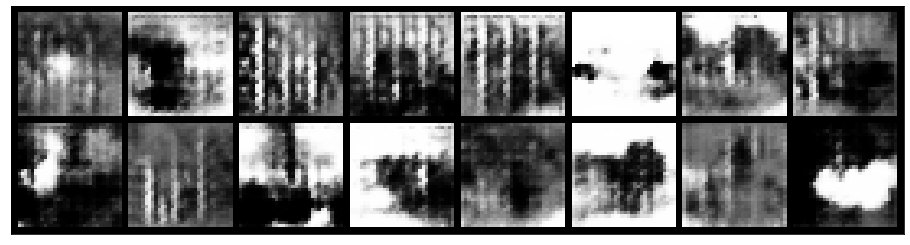

Epoch: 2,    G_loss: 2.5639077761650086,   D_loss: 0.5497287494850158  


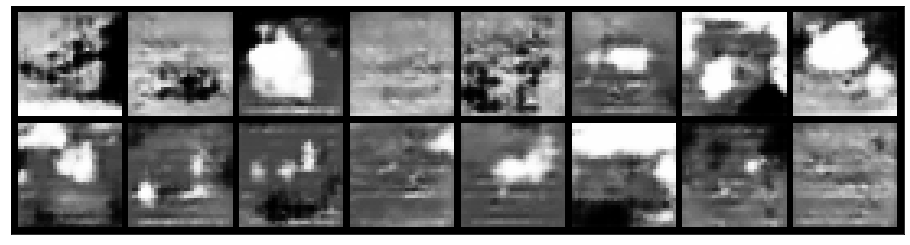

Epoch: 3,    G_loss: 2.625776354722977,   D_loss: 0.5056113989067078  


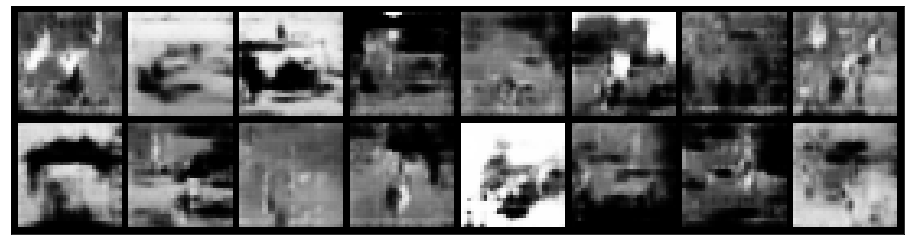

Epoch: 4,    G_loss: 2.660013782739639,   D_loss: 0.5000672287422419  


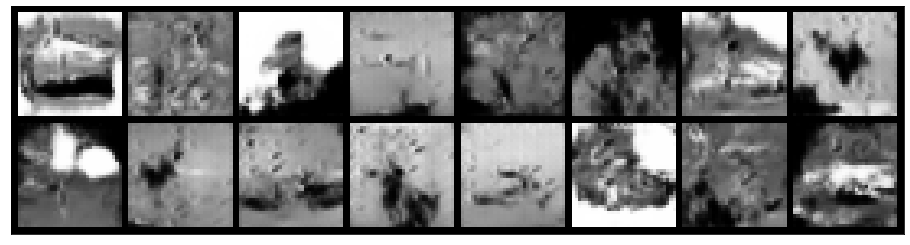

Epoch: 5,    G_loss: 2.7877427575302125,   D_loss: 0.4736846515095234  


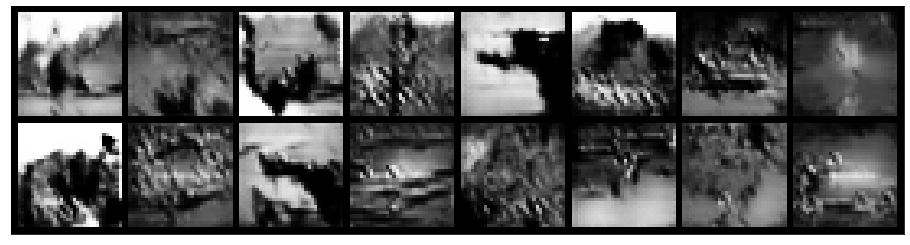

Epoch: 6,    G_loss: 2.8739176988220216,   D_loss: 0.43959276512503626  


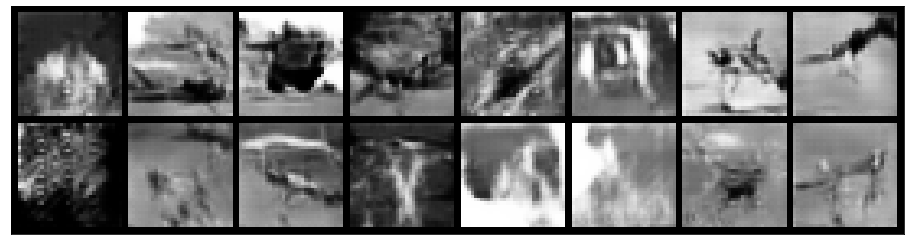

Epoch: 7,    G_loss: 2.9118727935409545,   D_loss: 0.4373753832679987  


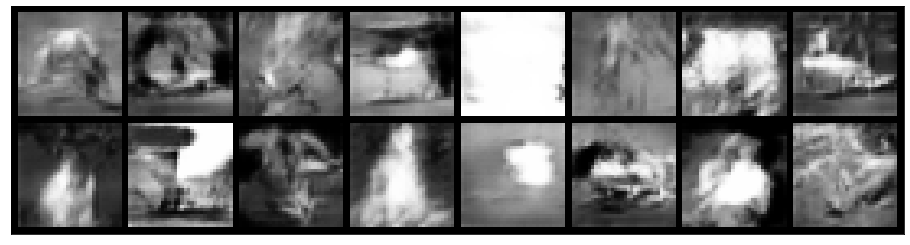

Epoch: 8,    G_loss: 3.0854765267944337,   D_loss: 0.39865867545604705  


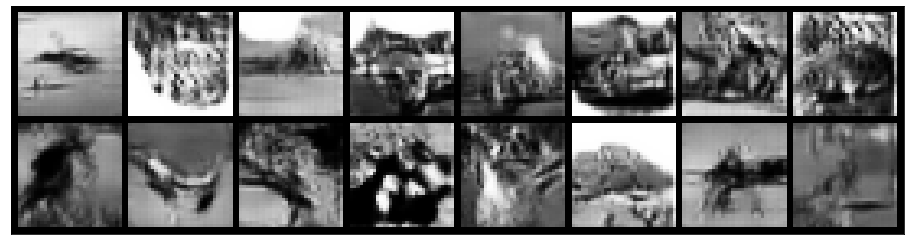

Epoch: 9,    G_loss: 3.2477501540756224,   D_loss: 0.36345916045963766  


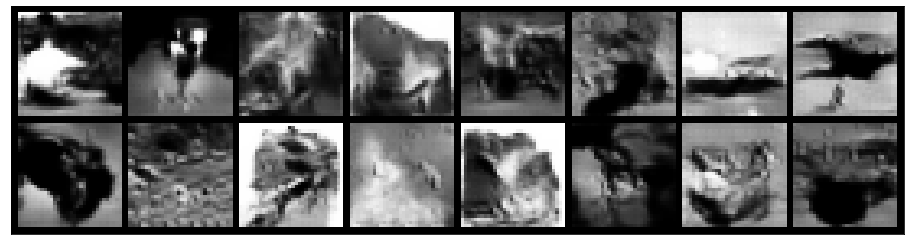

Epoch: 10,    G_loss: 3.3423648255062104,   D_loss: 0.3423352453136444  


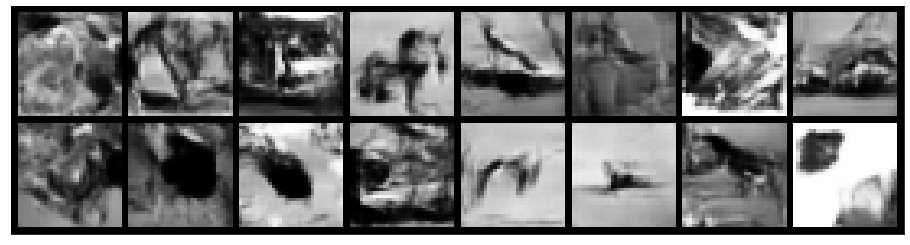

Epoch: 11,    G_loss: 3.5127074368667603,   D_loss: 0.31132451718091964  


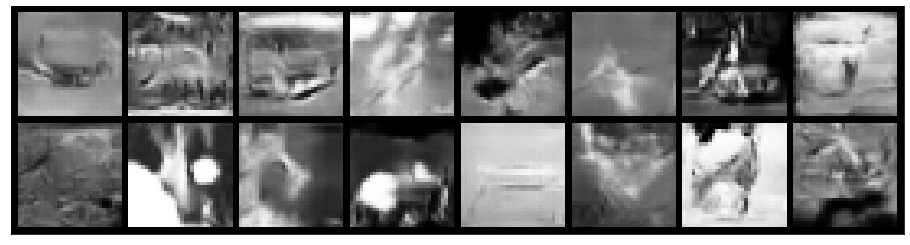

Epoch: 12,    G_loss: 3.770229013004303,   D_loss: 0.27253431047946214  


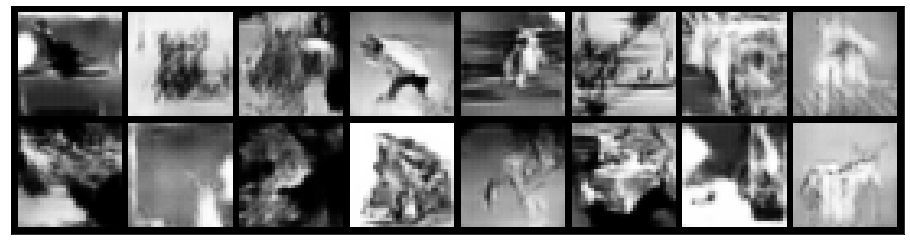

Epoch: 13,    G_loss: 3.8575871102905275,   D_loss: 0.251832408952713  


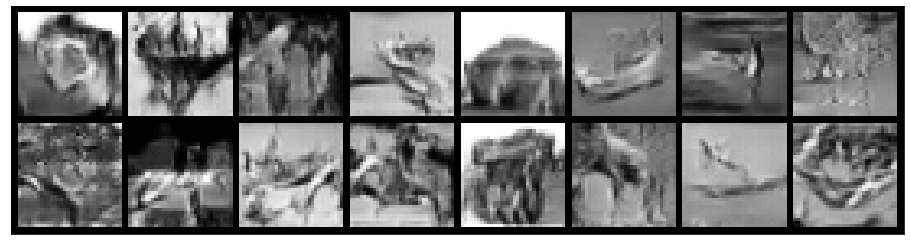

Epoch: 14,    G_loss: 4.096431286716461,   D_loss: 0.23203970724873244  


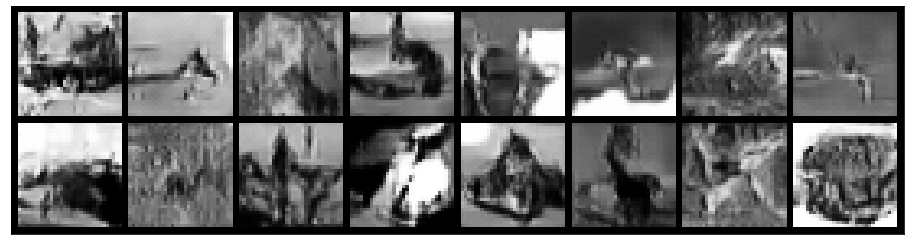

Epoch: 15,    G_loss: 4.13296096362114,   D_loss: 0.22433647976160048  


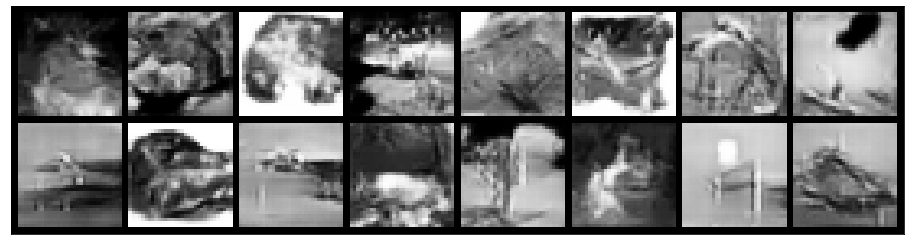

Epoch: 16,    G_loss: 4.293359366941452,   D_loss: 0.21977140499815345  


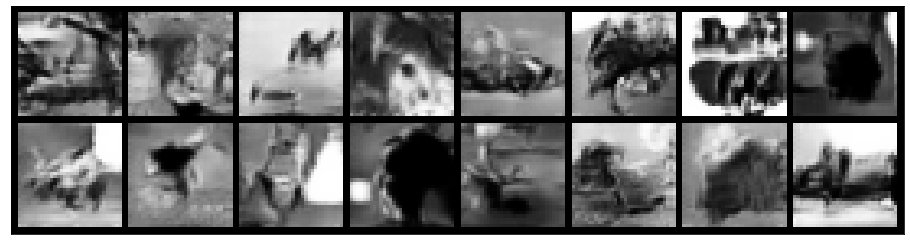

Epoch: 17,    G_loss: 4.428466094341278,   D_loss: 0.20504986419200896  


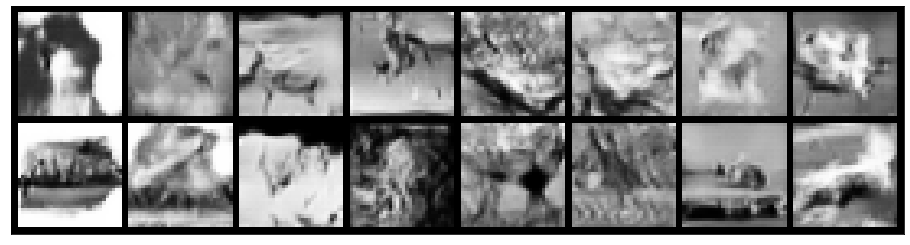

Epoch: 18,    G_loss: 4.509843908910751,   D_loss: 0.20192098644971848  


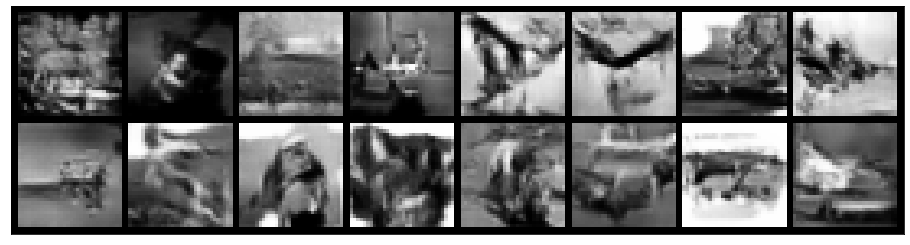

Epoch: 19,    G_loss: 4.578337047996521,   D_loss: 0.1852832924769819  


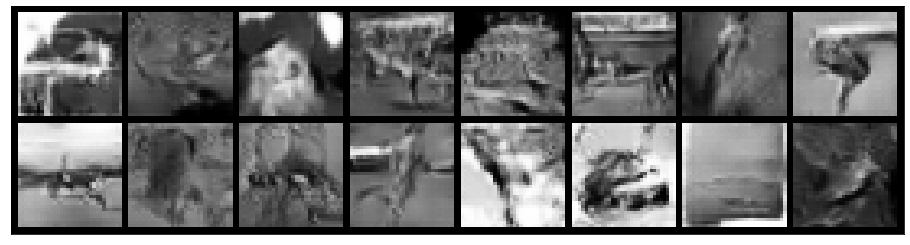

Epoch: 20,    G_loss: 4.734475260848999,   D_loss: 0.1877761242994666  


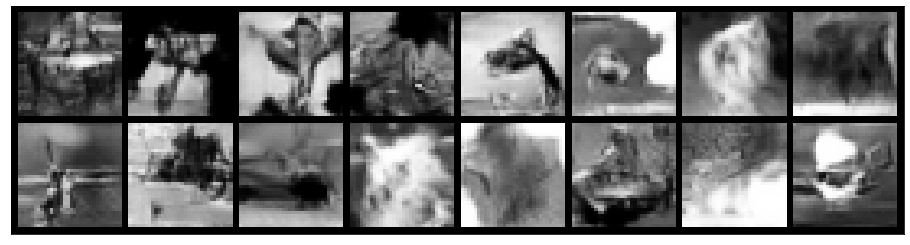

Epoch: 21,    G_loss: 4.839687827186585,   D_loss: 0.1789605040653795  


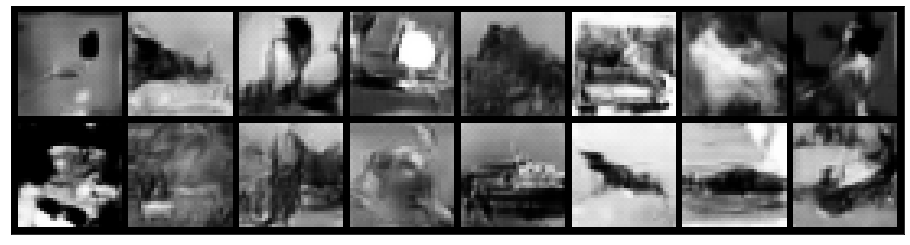

Epoch: 22,    G_loss: 4.944908393917084,   D_loss: 0.15847040967606008  


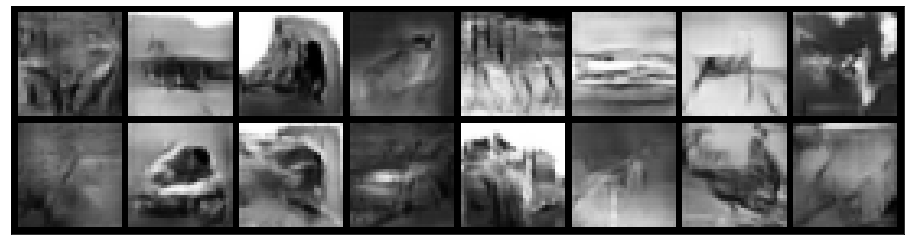

Epoch: 23,    G_loss: 5.133298908596039,   D_loss: 0.1699461042143032  


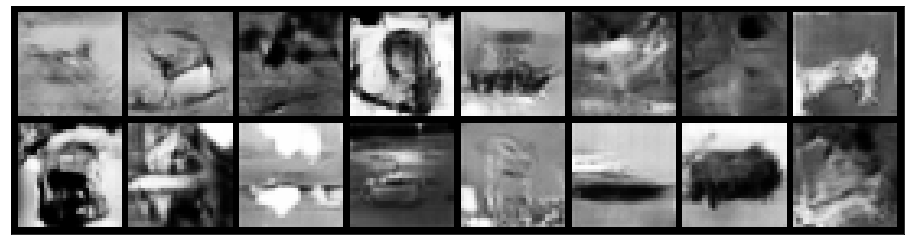

Epoch: 24,    G_loss: 5.193748018465042,   D_loss: 0.15546072001893074  


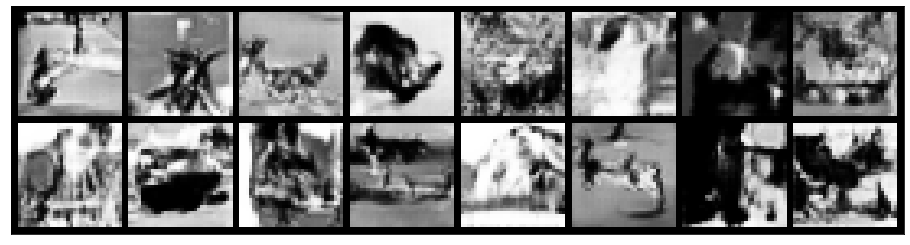

Epoch: 25,    G_loss: 5.333606454334259,   D_loss: 0.1408156081458926  


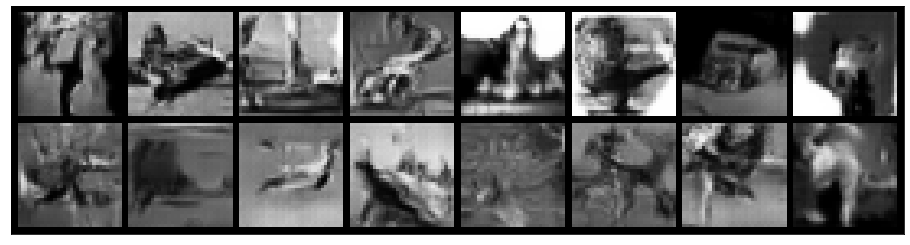

Epoch: 26,    G_loss: 5.325430324287415,   D_loss: 0.14668450287330895  


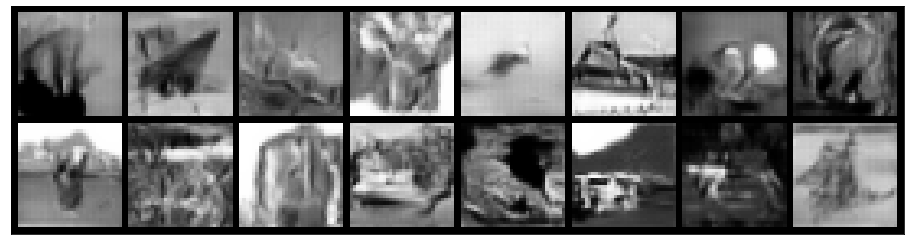

Epoch: 27,    G_loss: 5.4398408431053165,   D_loss: 0.1407892143928632  


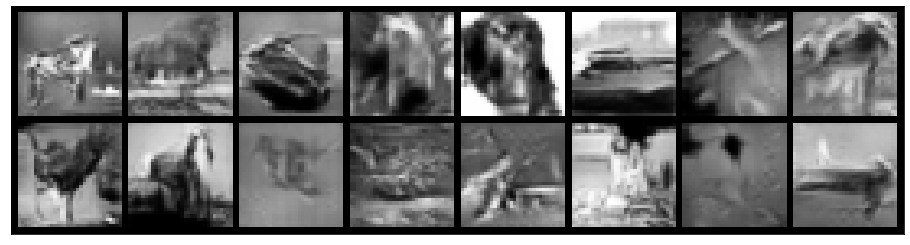

Epoch: 28,    G_loss: 5.621900868873596,   D_loss: 0.1351033548966609  


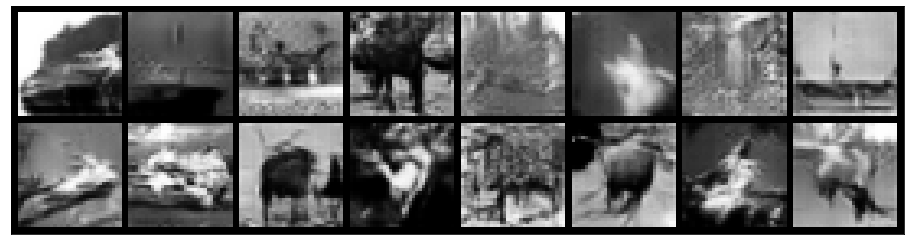

Epoch: 29,    G_loss: 5.676853033657074,   D_loss: 0.13067104807561264  


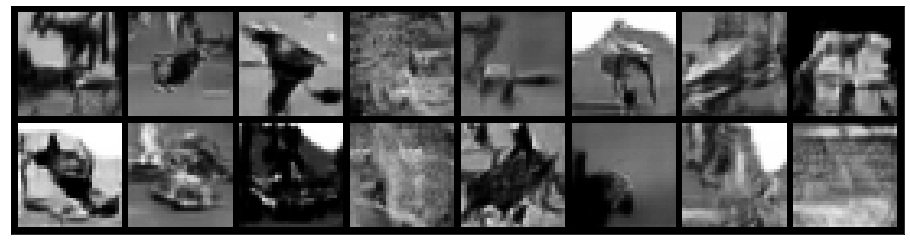

Epoch: 30,    G_loss: 5.7538124213981625,   D_loss: 0.132359301109761  


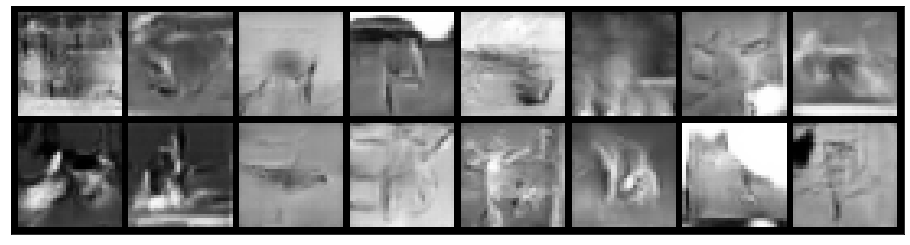

Epoch: 31,    G_loss: 5.834043281726837,   D_loss: 0.13117812501961365  


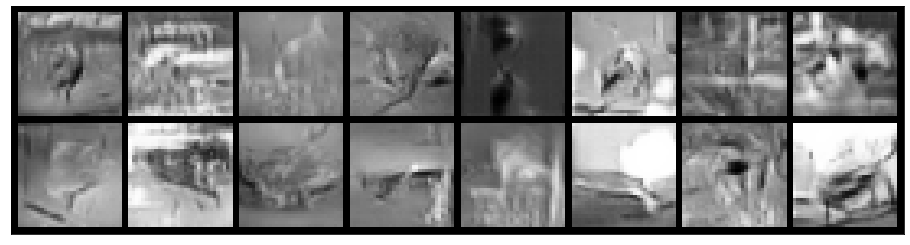

Epoch: 32,    G_loss: 5.77648828751564,   D_loss: 0.12612551501426847  


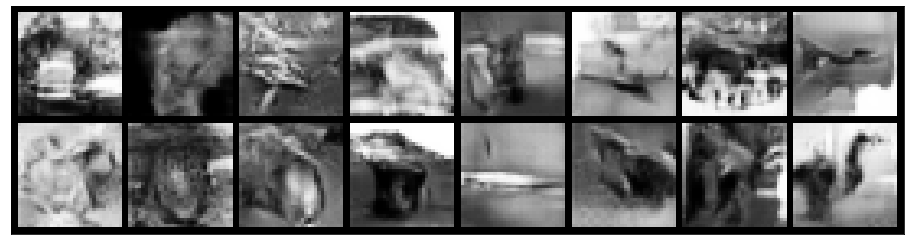

Epoch: 33,    G_loss: 6.004629659314156,   D_loss: 0.12691857247404753  


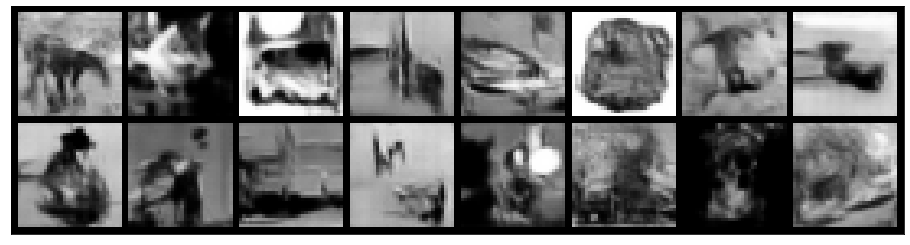

Epoch: 34,    G_loss: 6.021451944675445,   D_loss: 0.11605774470862001  


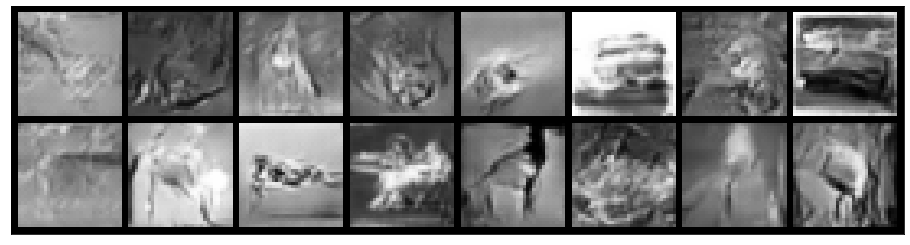

Epoch: 35,    G_loss: 6.032053523044586,   D_loss: 0.12501563409605995  


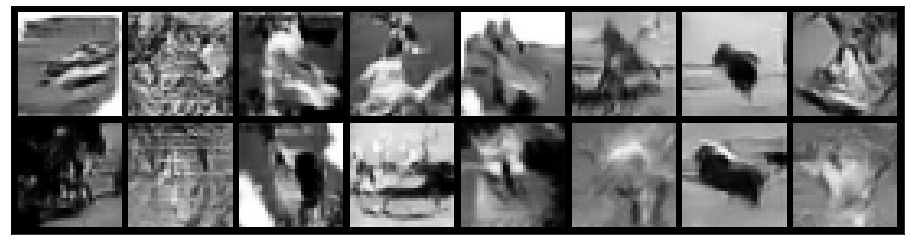

Epoch: 36,    G_loss: 6.117057208271026,   D_loss: 0.12412360151741654  


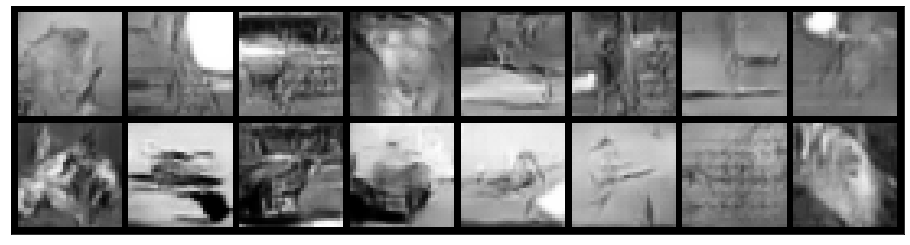

Epoch: 37,    G_loss: 6.1842371456336975,   D_loss: 0.11230794651228003  


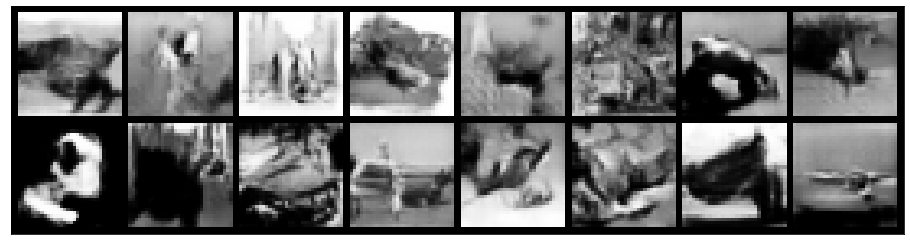

Epoch: 38,    G_loss: 6.255174978885651,   D_loss: 0.10907744652219117  


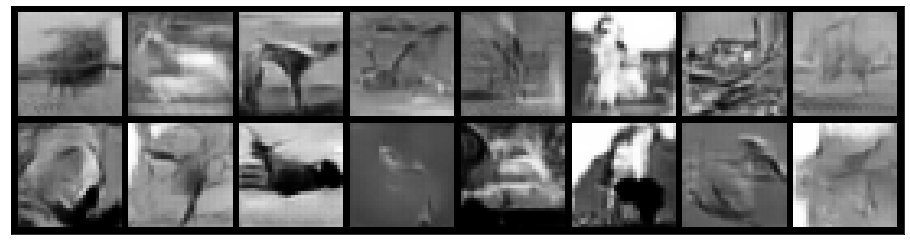

Epoch: 39,    G_loss: 6.240253852405548,   D_loss: 0.10452652397826313  


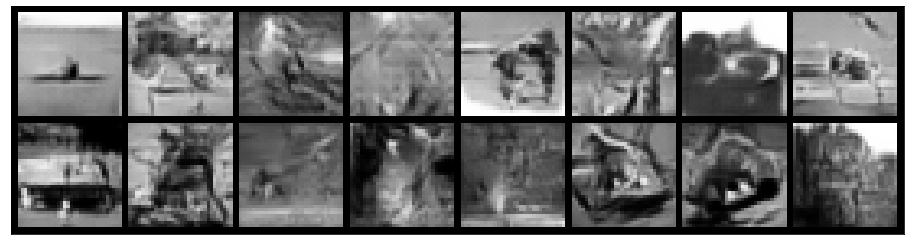

Epoch: 40,    G_loss: 6.37980922964096,   D_loss: 0.10696034354575909  


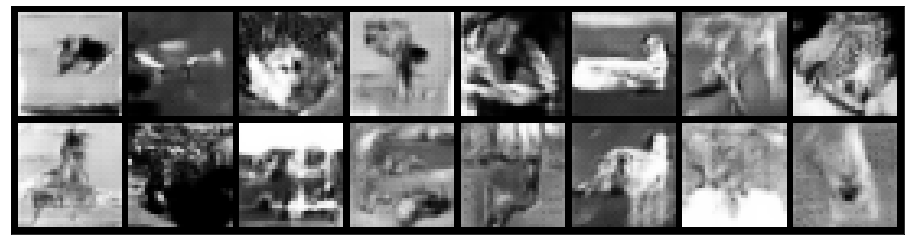

Epoch: 41,    G_loss: 6.575575254020691,   D_loss: 0.09865714391385438  


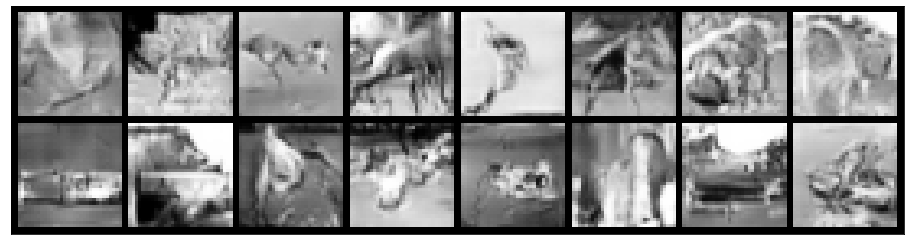

Epoch: 42,    G_loss: 6.605904676952362,   D_loss: 0.09579145487632137  


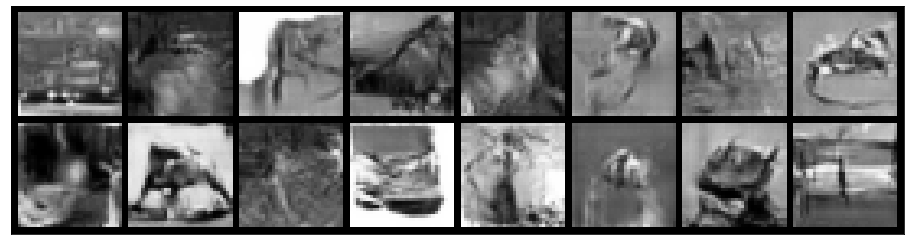

Epoch: 43,    G_loss: 6.655796501550674,   D_loss: 0.09578177138089203  


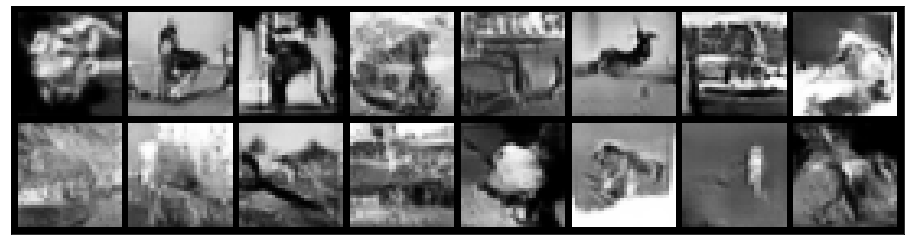

Epoch: 44,    G_loss: 6.540820052642823,   D_loss: 0.10269600228278898  


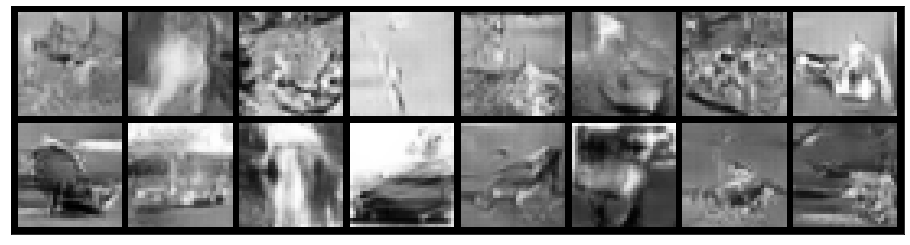

Epoch: 45,    G_loss: 6.6373940482711795,   D_loss: 0.09125291305303573  


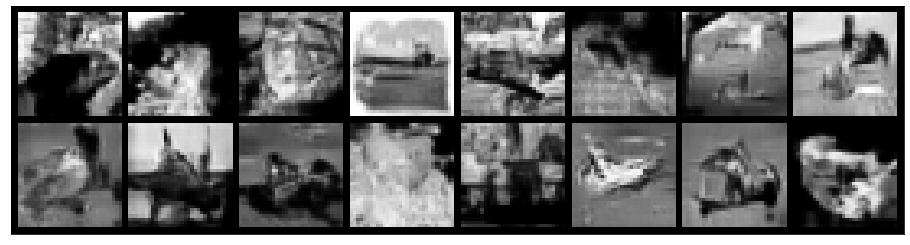

Epoch: 46,    G_loss: 6.737941703071594,   D_loss: 0.09982756328794173  


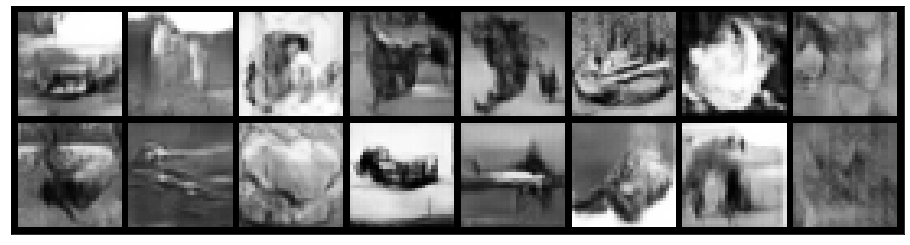

Epoch: 47,    G_loss: 6.72733112279892,   D_loss: 0.10191136147742393  


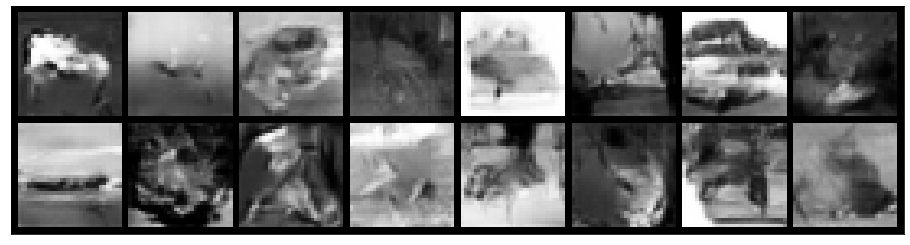

Epoch: 48,    G_loss: 6.941342595291138,   D_loss: 0.08848474009776022  


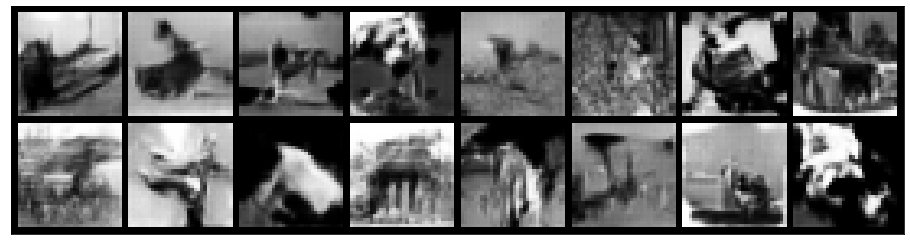

Epoch: 49,    G_loss: 6.894843506860733,   D_loss: 0.10293310077759205  


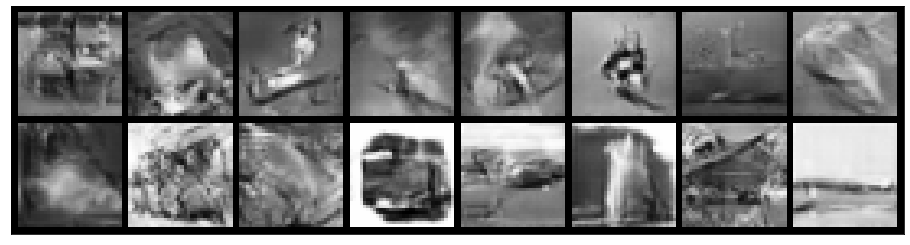

Epoch: 50,    G_loss: 6.9183302343177795,   D_loss: 0.08591892073596478  


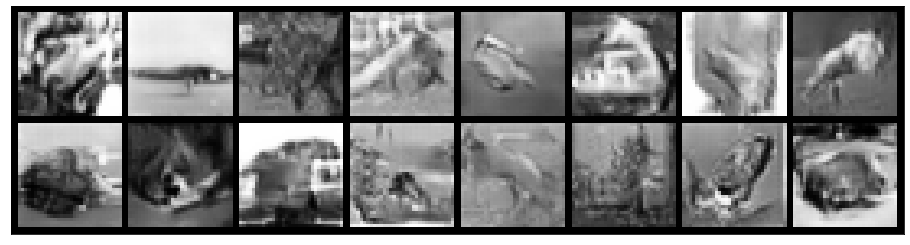

Epoch: 51,    G_loss: 6.865370891914368,   D_loss: 0.0891602395410277  


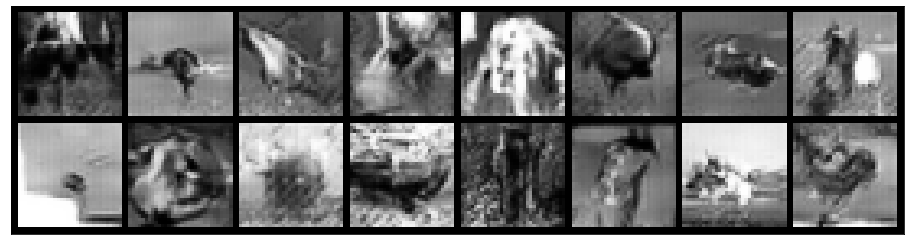

Epoch: 52,    G_loss: 6.982207210159301,   D_loss: 0.087818284298582  


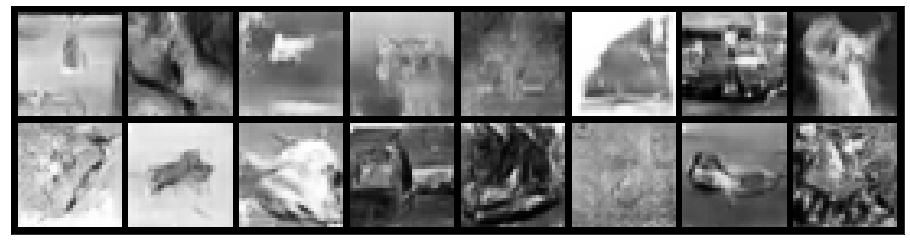

Epoch: 53,    G_loss: 6.979341793136597,   D_loss: 0.0891417590724607  


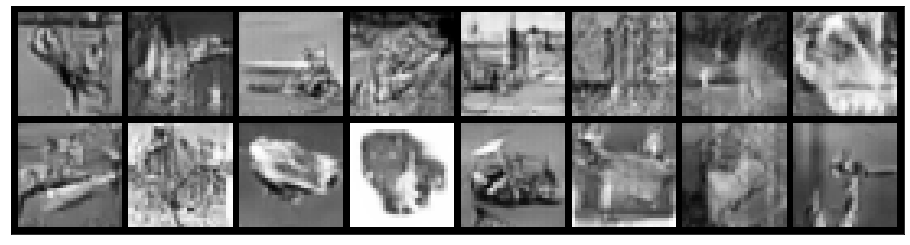

Epoch: 54,    G_loss: 7.08590548921585,   D_loss: 0.08343567261151504  


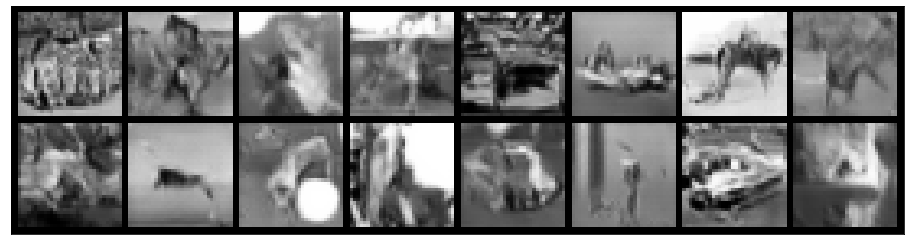

Epoch: 55,    G_loss: 7.136259124698639,   D_loss: 0.08842913844966097  


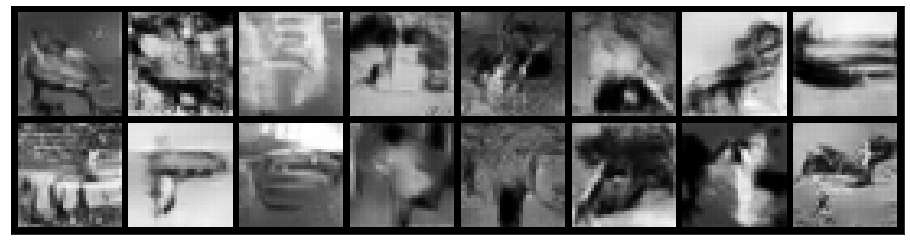

Epoch: 56,    G_loss: 7.3273114745426176,   D_loss: 0.08122321154722478  


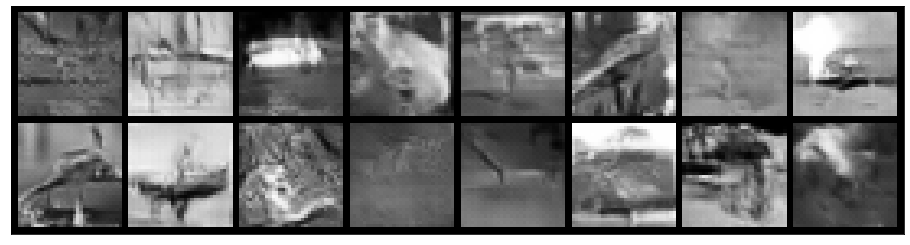

Epoch: 57,    G_loss: 7.254393732528687,   D_loss: 0.09042797906449064  


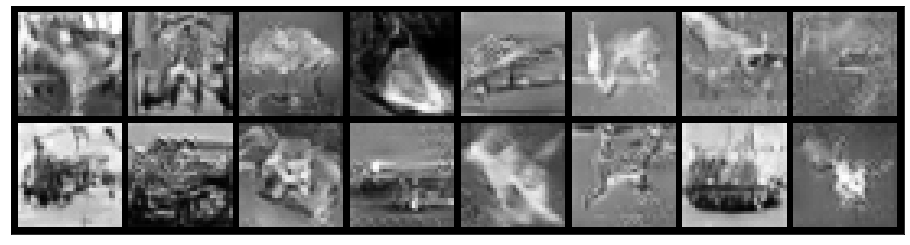

Epoch: 58,    G_loss: 7.241343700966835,   D_loss: 0.09365281445770525  


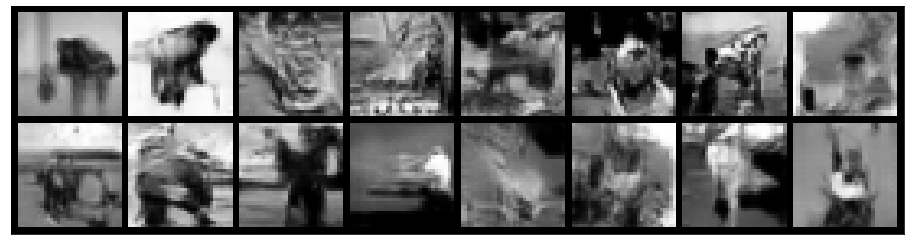

Epoch: 59,    G_loss: 7.302582927589416,   D_loss: 0.08069776274960605  


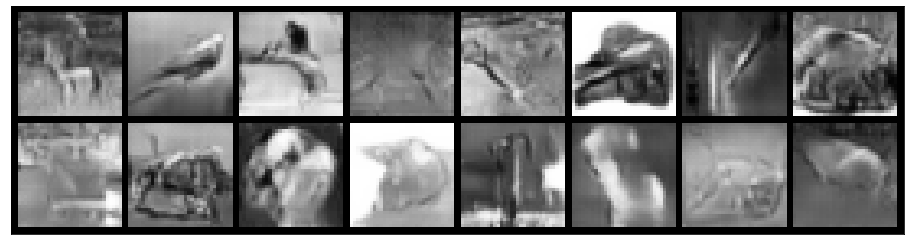

Epoch: 60,    G_loss: 7.2831286923885346,   D_loss: 0.07868713590547209  


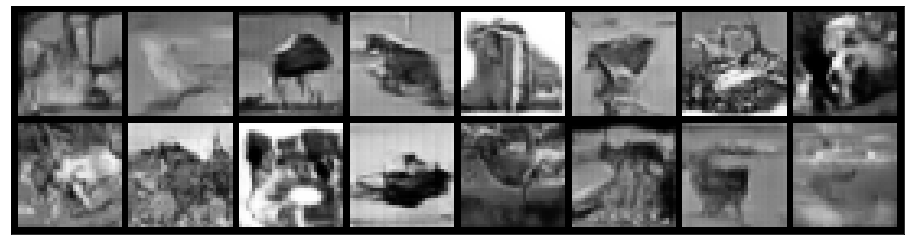

Epoch: 61,    G_loss: 7.453513753757477,   D_loss: 0.07601954770425334  


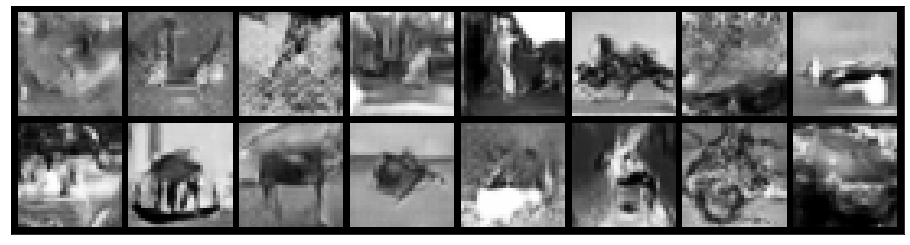

Epoch: 62,    G_loss: 7.51518422920227,   D_loss: 0.08453504283676623  


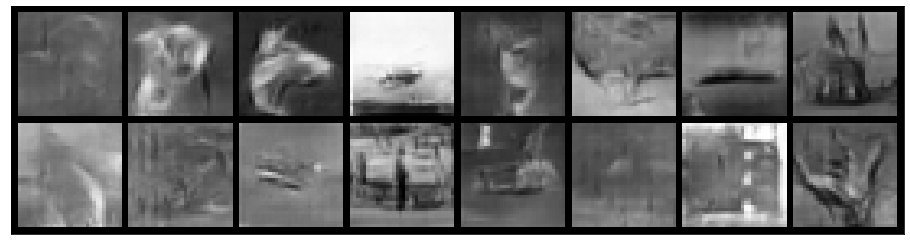

Epoch: 63,    G_loss: 7.601307079982758,   D_loss: 0.07532455103073968  


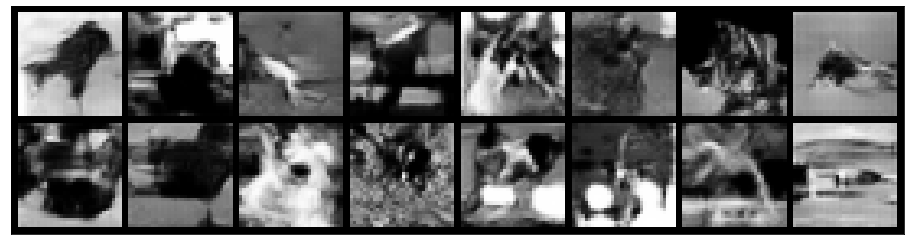

Epoch: 64,    G_loss: 7.560555371704101,   D_loss: 0.08562817008145153  


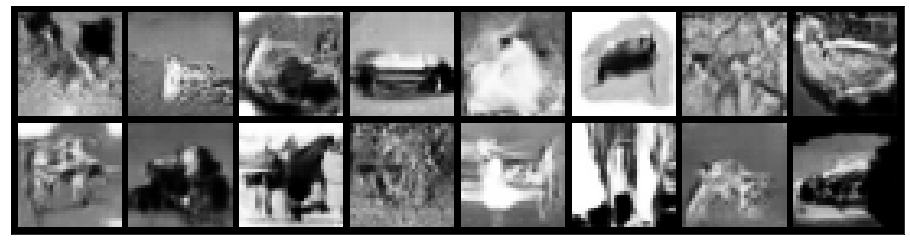

Epoch: 65,    G_loss: 7.579929378585815,   D_loss: 0.0720157149364415  


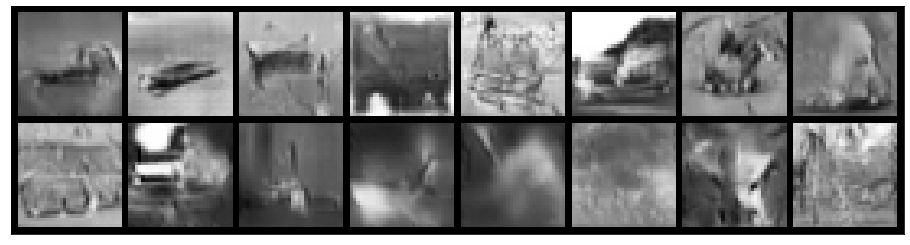

Epoch: 66,    G_loss: 7.613127609806061,   D_loss: 0.0858270280315273  


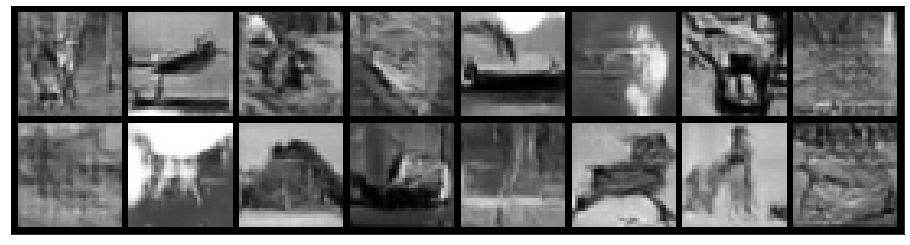

Epoch: 67,    G_loss: 7.579890083026886,   D_loss: 0.0749048820786632  


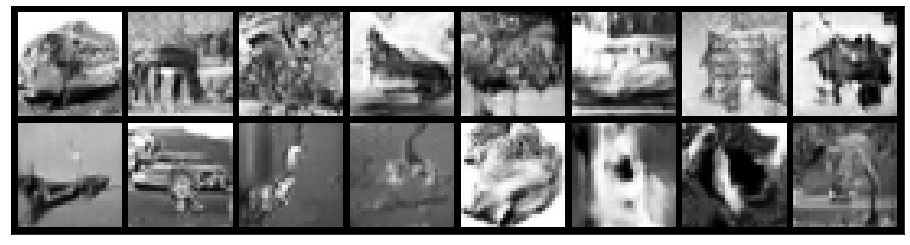

Epoch: 68,    G_loss: 7.6300170214176175,   D_loss: 0.07559756278957706  


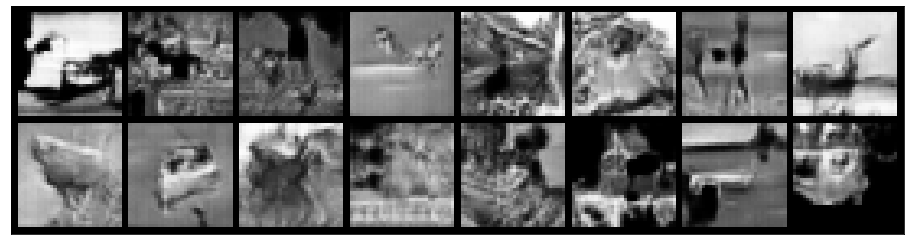

Epoch: 69,    G_loss: 7.716478463478088,   D_loss: 0.072993404721939  


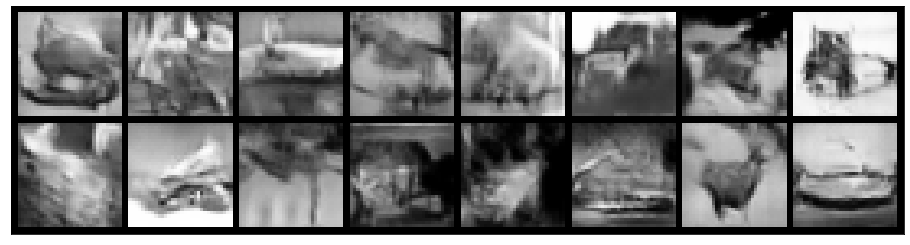

Epoch: 70,    G_loss: 7.783934210643769,   D_loss: 0.07170381451225258  


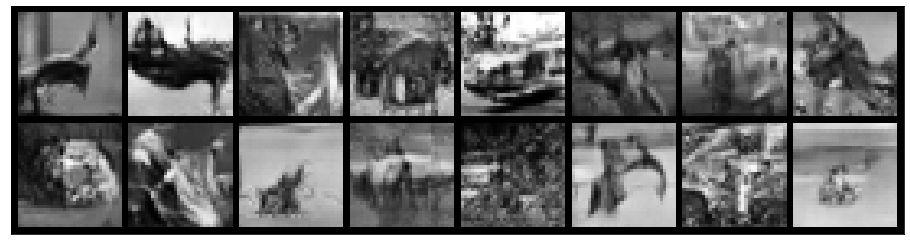

Epoch: 71,    G_loss: 8.20740014447689,   D_loss: 0.07266866718839854  


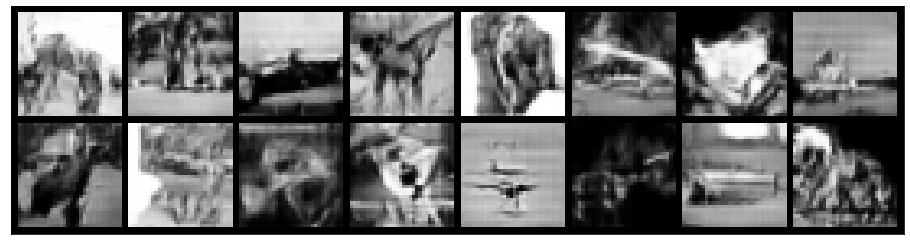

Epoch: 72,    G_loss: 7.929866678905487,   D_loss: 0.06524543184864975  


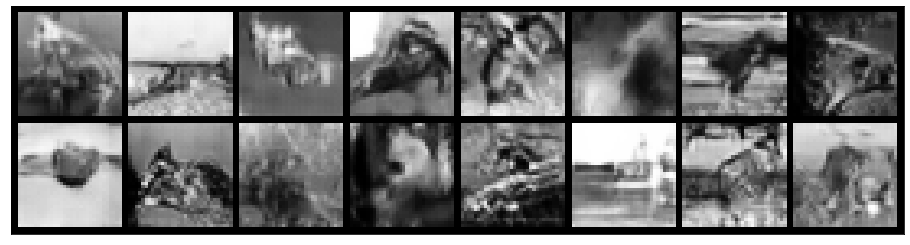

Epoch: 73,    G_loss: 7.637264013137817,   D_loss: 0.07853691310123512  


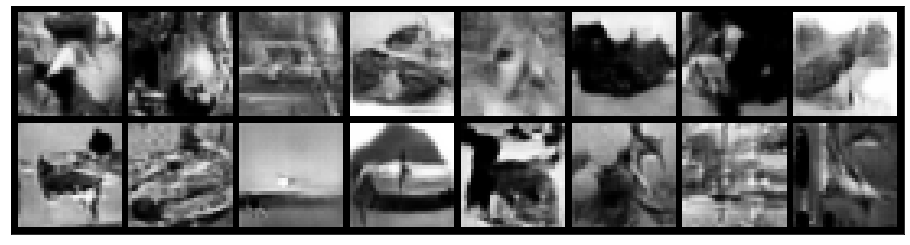

Epoch: 74,    G_loss: 7.76840244272232,   D_loss: 0.07358747682385845  


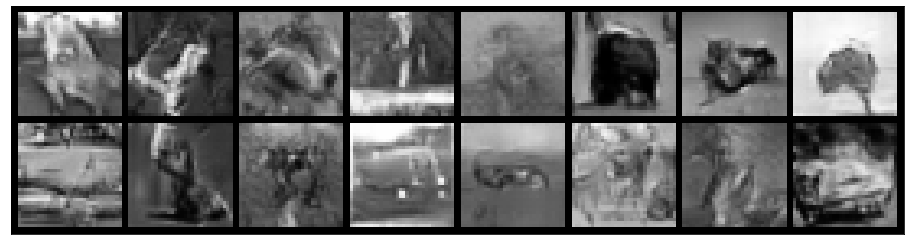

Epoch: 75,    G_loss: 7.732368213882446,   D_loss: 0.07319988648675266  


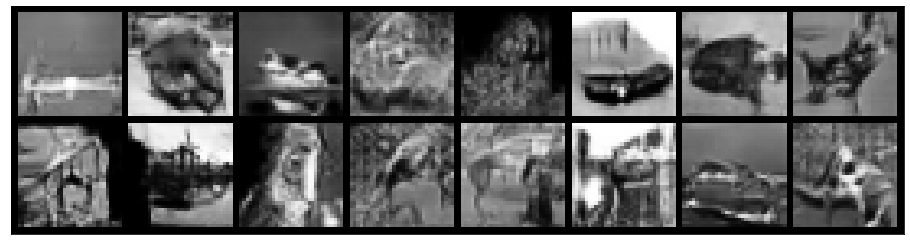

Epoch: 76,    G_loss: 7.892797678184509,   D_loss: 0.06962323987837007  


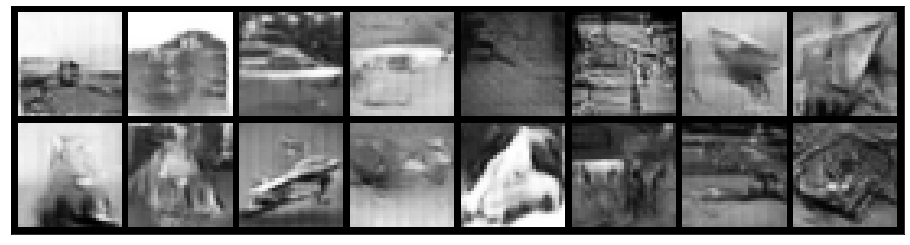

Epoch: 77,    G_loss: 7.776970941562652,   D_loss: 0.08219732183930929  


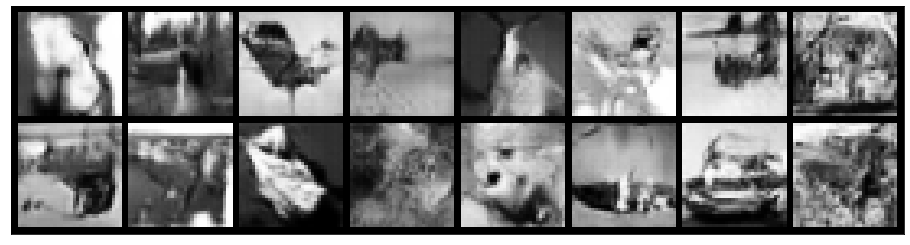

Epoch: 78,    G_loss: 7.846703862495422,   D_loss: 0.06400270696341293  


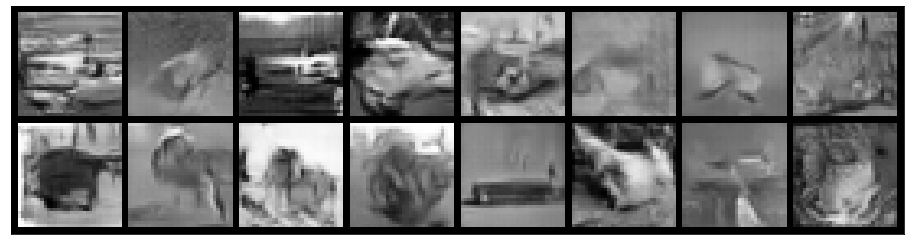

Epoch: 79,    G_loss: 7.895506265172958,   D_loss: 0.07120674906534026  


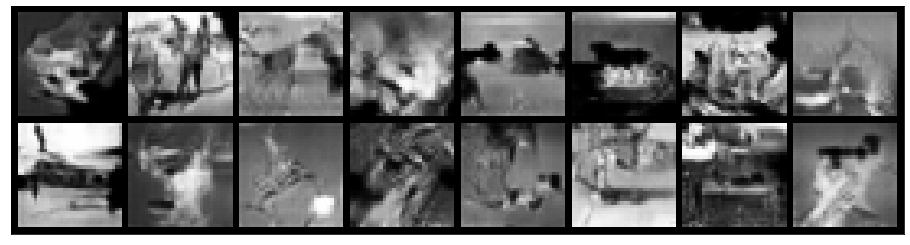

In [ ]:


for epoch in range (num_epochs):
    gen_loss= 0.0
    dis_loss= 0.0
    
    for i, (images, _) in enumerate(train_loader):

        images = Variable(images)
        labels_real = Variable(torch.ones(batch_size))       # Labels for real images - all ones
        labels_fake = Variable(torch.zeros(batch_size))      # Labels for fake images - all zeors
        labels_real = labels_real.unsqueeze(1)
        labels_fake = labels_fake.unsqueeze(1)
        

        # Train the discriminator
        discriminator.zero_grad()
        outputs = discriminator(images)
        labels_real = labels_real.float()
        loss_real = criterion(outputs, labels_real)

        z = torch.randn(batch_size, z_size)
        images_fake = generator(z)
        outputs = discriminator(images_fake.detach())
        labels_fake = labels_fake.float()
        loss_fake = criterion(outputs, labels_fake)

        loss_d = loss_real + loss_fake              # Calculate the total loss
        loss_d.backward()                           # Backpropagation
        optimizer_d.step()                          # Update the weights

        # Train the generator
        # Draw samples from the input distribution and pass to generator
        z = torch.randn(batch_size, z_size)
        images_fake = generator(z)

        # Pass the genrated images to discriminator
        outputs = discriminator(images_fake)

        generator.zero_grad()
        loss_g = criterion(outputs, labels_real)    # Calculate the loss
        loss_g.backward()                           # Backpropagation
        optimizer_g.step()                          # Update the weights

        gen_loss += loss_g.item()
        dis_loss += loss_d.item()
        
          
    print('Epoch: {},    G_loss: {},   D_loss: {}  '.format(epoch, gen_loss/(i+1), dis_loss/(i+1)))
            
    samples = generator(z).detach()
    samples = samples.view(batch_size,1, 32, 32)
    imshow(samples)
    
    if (epoch+1) == 1:
        images = images.view(images.size(0), 1, 32, 32)
        save_image(denorm(images.data), './data/GAN/real_images.png')
        
    images_fake = images_fake.view(images_fake.size(0), 1, 32, 32)
    save_image(denorm(images_fake.data), './data/GAN/images_fake-%d.png' %(epoch+1))
        
torch.save(generator.state_dict(),'./generator.pk1')
torch.save(discriminator.state_dict(),'./discriminator.pk1')


    

